<a href="https://colab.research.google.com/github/DaniyalK03/PML/blob/main/Autoencoder_Image_Reproduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Machine Learning for Physicists
## Coursework C - Part 2


For both of these tasks we want you to implement autoencoder networks that:
- Train on randomly generated circles (using the circle_generator function below)
- Use 27x27 pixel images
- Use no more than 30,000 randomly generated samples (e.g. batchsize 30 and 1000 steps, or batchsize 1000 and 30 steps, or anywhere inbetween) in training the final networks for each task
- Use the mean_squared_error loss function
- Fulfil the network size requirement listed in the task (can be verifired using the print_layers function, after the network is partially trained)

### Task 1:
Implement any network design, but the bottleneck must contain no more than 9 neurons.

### Task 2:
Implement any network design, but the bottleneck must contain no more than 3 neurons.



#### Practicalities
You should use this notebook for your work and upload it to  Moodle. You are expected to use TensorFlow and Keras to complete these tasks. The notebook should be self-contained and able to be executed if necessary. Marks will be awarded for (roughly equally weighted):
- Overall notebook clarity (both in terms of good coding practice and coherent discussion)
- Task 1 performance (0.02 is a good target cost to do better than)
- Task 2 performance ( a good target here is left for the student to determine)



# Coursework C - Part 2 Introduction

**Submission by SN: 21015796**

The following notebook is submitted coursework C for PHAS0056.

This notebook compares minimum cost for an autoencoder with a bottleneck of 9 neurons and an autoencoder with a bottleneck of 1 neuron when tested via ability to reproduce an image of a generated circle.

Findings below imply that reducing an autoencoder's bottleneck to too few neurons reduces the ability of necessary information to be encoded and therefore reproduced.

It is exemplified below with a comparison between the generated circle and the attempted reproduction.

The following code is adapted and structured similar to [1].

*Bibliography*

[1] R. Nichol, "Week4_Autoencoder.ipynb", UCL, PHAS:0056, 2024

In [ ]:
###############################################################################
# Importing necessary backend modules and libraries
# Same backend from [1]

import matplotlib.pyplot as plt
import numpy as np
import math

# Importing TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Setting up for later plotting
import matplotlib.style
import matplotlib as mpl
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=100 # Provides appropriate size for plots

In [ ]:
#A big messy function to do the training
# model -- our keras neural model autoencoder
# image_generator -- a function to generate random images for the training (see below for examples)
# img_size -- the size of our image in pixels
# batchsize -- the number of images to include in each training batch
# steps -- the number of steps taken in the training
#
# returns an array of the costs
def generate_and_train(model,image_generator,img_size,batchsize,steps):

    #Generate an array of the numbers 1 to img_size and create a meshgrid from them
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)

    #Now create a test image using 1 call to image_generator
    #y_test=np.zeros([1,pixels,pixels,1])
    #y_test[:,:,:,0]=image_generator(1,x,y)

    #Now create the empty arrays for the images and cost
    y_in=np.zeros([batchsize,img_size,img_size,1])
    y_target=np.zeros([batchsize,img_size,img_size,1])
    cost=np.zeros(steps)

    #Loop through the steps, get a random batch of samples, train the model, repeat
    for k in range(steps):
        # produce samples:
        y_in[:,:,:,0]=image_generator(batchsize,x,y)
        y_target=np.copy(y_in) # autoencoder wants to reproduce its input!

        # do one training step on this batch of samples:
        cost[k]=model.train_on_batch(y_in,y_target)

    return cost,y_target

def get_test_image(image_generator,img_size):
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)

    #Now create a test image using 1 call to image_generator
    y_test=np.zeros([1,img_size,img_size,1])
    y_test[:,:,:,0]=image_generator(1,x,y)
    return y_test

# A function to generate and plot a single test image and the output of our model
# only to be called after training the model
def plot_test_image(model,image_generator,img_size):
    #Get random test image
    y_test=get_test_image(image_generator,img_size)

    #Create the output image
    y_test_out=model.predict_on_batch(y_test)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(y_test[0,:,:,0],origin='lower')
    ax[0].set_title("Input")
    ax[1].imshow(y_test_out[0,:,:,0],origin='lower')
    ax[1].set_title("Output")

def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize,pixels,pixels,channels).
    After a call to the visualization routine, y_target will contain
    the last set of training images, so you could feed those in here.
    """
    layer_features=get_layer_activations(network,y_in)
    #print(layer_features)
    for idx,feature in enumerate(layer_features):
        s=np.shape(feature)
        print("Layer "+str(idx)+": "+str(s[1]*s[2]*s[3])+" neurons / ", s)

def get_layer_activation_extractor(network):
    #print(network.inputs)
    #for layer in network.layers:
    #    print(layer.output)
    return(keras.Model(inputs=network.inputs,
                            outputs=[layer.output for layer in network.layers]))

def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor=get_layer_activation_extractor(network)
    #print(extractor)
    layer_features = extractor(y_in)
    return layer_features


## Circle generator


In [ ]:
# A simple image generator that returns an array of batchsize images
# each image has a size of x * y pixels
# in this image each image has a randomly placed circle (and the circle is of random size)
def circle_generator(batchsize,x,y):
    R=np.random.uniform(size=batchsize)
    x0=np.random.uniform(size=batchsize,low=-1,high=1)
    y0=np.random.uniform(size=batchsize,low=-1,high=1)
    return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) )


## Task 1

In [ ]:
# Setting up autoencoder with bottleneck of 9 neurons similar to example notebook [1]
model1=keras.models.Sequential()

model1.add(keras.layers.Conv2D(4, 5, input_shape=(27,27,1), activation="relu",padding='same')) # 27 x 27 pixels input
model1.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down

model1.add(keras.layers.Conv2D(4, 5, activation="relu",padding='same'))
model1.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down

model1.add(keras.layers.Conv2D(1,3, activation="relu",padding='same'))
model1.add(keras.layers.UpSampling2D(size=(3,3))) # up

model1.add(keras.layers.Conv2D(4,5, activation="relu",padding='same'))
model1.add(keras.layers.UpSampling2D(size=(3,3))) # up

model1.add(keras.layers.Conv2D(4,5, activation="relu",padding='same'))
model1.add(keras.layers.Conv2D(1,3, activation="relu",padding='same'))

# Compiling model using adam as optimiser for efficiency
model1.compile(loss='mean_squared_error', optimizer='adam')

model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 4)         104       
                                                                 
 average_pooling2d (Average  (None, 9, 9, 4)           0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 4)           404       
                                                                 
 average_pooling2d_1 (Avera  (None, 3, 3, 4)           0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 1)           37        
                                                                 
 up_sampling2d (UpSampling2  (None, 9, 9, 1)           0

The above code has been changed to use ReLu as an activation efficiency to better minimise cost values.

Success - Below target: Cost = 0.01679280586540699


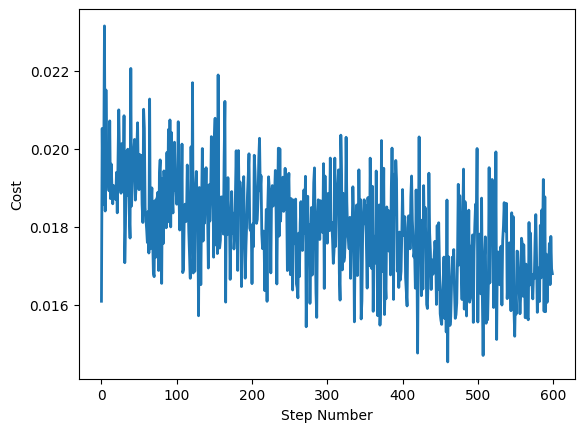

In [ ]:
# Training the model on 30000 samples
steps=600
cost,y_target=generate_and_train(model1,circle_generator,img_size=27,batchsize=50,steps=steps)

#Plot the cost [1]
fig, ax = plt.subplots()
stepArray=np.arange(steps)
ax.plot(stepArray,cost,linewidth=2.0)
ax.set_xlabel("Step Number")
ax.set_ylabel("Cost")

# Print final cost reached and if it is below desired cost of 0.02
if cost[-1] < 0.02:
  print(f"Success - Below target: Cost = {cost[-1]}")
else:
  print(f"Retry - Above target: Cost = {cost[-1]}")

This autoencoder is functioning correctly as the cost is smaller than the desired target cost and clearly the result is a relatively successful reproduction.

Note using greater steps with smaller batchsize will yield lower costs at risk of reducing computational efficiency (longer runtimes).

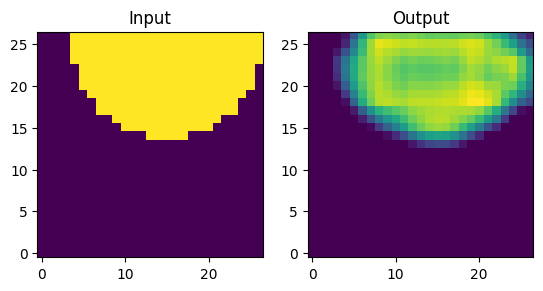

In [ ]:
# Displaying original generated circle and the reproduced output of the autoencoder
plot_test_image(model1,circle_generator,27)

In [ ]:
print_layers(model1,y_target)

Layer 0: 2916 neurons /  (50, 27, 27, 4)
Layer 1: 324 neurons /  (50, 9, 9, 4)
Layer 2: 324 neurons /  (50, 9, 9, 4)
Layer 3: 36 neurons /  (50, 3, 3, 4)
Layer 4: 9 neurons /  (50, 3, 3, 1)
Layer 5: 81 neurons /  (50, 9, 9, 1)
Layer 6: 324 neurons /  (50, 9, 9, 4)
Layer 7: 2916 neurons /  (50, 27, 27, 4)
Layer 8: 2916 neurons /  (50, 27, 27, 4)
Layer 9: 729 neurons /  (50, 27, 27, 1)


This autoencoder with a bottleneck of 9 neurons is effective as it has preserved colours, shape and circle location relatively well in the reproduction when compared to the original.

## Task 2

In [ ]:
# Setting up autoencoder with bottleneck of 1 neuron similar to example notebook [1]
model2=keras.models.Sequential()

model2.add(keras.layers.Conv2D(4, 5, input_shape=(27,27,1), activation="relu",padding='same')) # 27 x 27 pixels input
model2.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down


model2.add(keras.layers.Conv2D(1, 3, activation="relu",padding='same')) # Changed to 1 to reflect convolution to a single neuron
model2.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) # down

model2.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='valid')) # down but this has padding changed to valid to actually dimensionally reduce the input down to a single neuron
model2.add(keras.layers.UpSampling2D(size=(3,3))) # up

#model2.add(keras.layers.Conv2D(1,3, activation="relu",padding='same')) # Layer repeated so removed for efficiency
model2.add(keras.layers.UpSampling2D(size=(3,3))) # up

model2.add(keras.layers.Conv2D(4,5, activation="relu",padding='same'))
model2.add(keras.layers.UpSampling2D(size=(3,3))) # up

#model2.add(keras.layers.Conv2D(4,5, activation="relu",padding='same')) # Layer repeated so removed for efficiency
model2.add(keras.layers.Conv2D(1,3, activation="relu",padding='same'))

# Compiling model using adam as optimiser for efficiency
model2.compile(loss='mean_squared_error', optimizer='adam')

model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 27, 27, 4)         104       
                                                                 
 average_pooling2d_2 (Avera  (None, 9, 9, 4)           0         
 gePooling2D)                                                    
                                                                 
 conv2d_7 (Conv2D)           (None, 9, 9, 1)           37        
                                                                 
 average_pooling2d_3 (Avera  (None, 3, 3, 1)           0         
 gePooling2D)                                                    
                                                                 
 average_pooling2d_4 (Avera  (None, 1, 1, 1)           0         
 gePooling2D)                                                    
                                                      

Retry - Above target: Cost = 0.11581593006849289


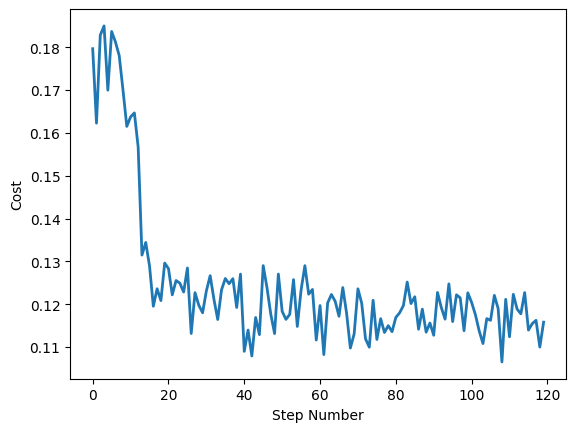

In [ ]:
# Training the model on 30000 samples
steps2=120
cost2,y_target2=generate_and_train(model2,circle_generator,img_size=27,batchsize=250,steps=steps2)

#Plot the cost [1]
fig, ax = plt.subplots()
stepArray2=np.arange(steps2)
ax.plot(stepArray2,cost2,linewidth=2.0)
ax.set_xlabel("Step Number")
ax.set_ylabel("Cost")

# Print final cost reached and if it is below desired cost of 0.02
if cost2[-1] < 0.02:
  print(f"Success - Below target: Cost = {cost2[-1]}")
else:
  print(f"Retry - Above target: Cost = {cost2[-1]}")

This autoencoder is functioning incorrectly as the cost is larger than the previous target cost and the result is an unsuccessful reproduction.

Even if we account that the bottleneck is 3 times smaller than the above bottleneck, the final cost of this autoencoder still is over 3 times larger than the above.

Note using greater steps with smaller batchsize will yield lower costs at risk of reducing computational efficiency (longer runtimes).

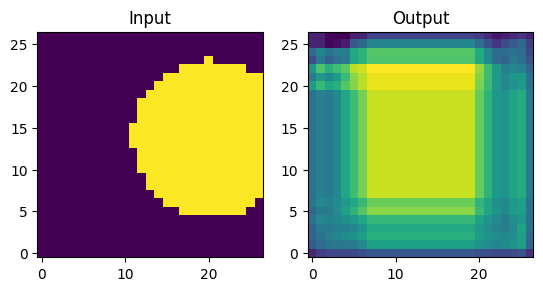

In [ ]:
# Displaying original generated circle and the reproduced output of the autoencoder
plot_test_image(model2,circle_generator,27)

In [ ]:
print_layers(model2,y_target2)

Layer 0: 2916 neurons /  (250, 27, 27, 4)
Layer 1: 324 neurons /  (250, 9, 9, 4)
Layer 2: 81 neurons /  (250, 9, 9, 1)
Layer 3: 9 neurons /  (250, 3, 3, 1)
Layer 4: 1 neurons /  (250, 1, 1, 1)
Layer 5: 9 neurons /  (250, 3, 3, 1)
Layer 6: 81 neurons /  (250, 9, 9, 1)
Layer 7: 324 neurons /  (250, 9, 9, 4)
Layer 8: 2916 neurons /  (250, 27, 27, 4)
Layer 9: 729 neurons /  (250, 27, 27, 1)


This autoencoder with a bottleneck of 1 neuron is ineffective as it is unable to preserve all the essential information necessary for a successful reproduction. The autoencoder with a single neuron bottleneck has only preserved the colour yet the information for shape or circle location has not been encoded. This has resulted in an ineffective reproduction.